In [2]:
import pandas as pd

In [40]:
from scipy import stats
import numpy as np

## Remove outliers using Z score

def drop_coordinates_outliers(data):
    data = data.copy()
    print('Data shape before removing outliers: ', data.shape)
    data = data[((data.lat > 0.0)&(data.lon> 0.0))]
    z_lat, z_lon = np.abs(stats.zscore(data.lat)), np.abs(stats.zscore(data.lon))
    
    threshold = 2.5
    lat_outliers = np.where(z_lat > threshold)
    lon_outliers = np.where(z_lon > threshold)
    
    data_no_outliers = data.loc[~data.index.isin(np.concatenate((lat_outliers[0], lon_outliers[0])))].reset_index(drop=True)
    print('Data shape after removing outliers: ', data.shape)
    return data_no_outliers

### First of all we need to know the bounds of area which we will use for training

In [41]:
valid = pd.read_csv('./valid.csv')
valid = valid.drop_duplicates()

valid['hour'] = pd.to_datetime(valid['hour'], unit='s')

In [42]:
valid_no_outliers = drop_coordinates_outliers(data=valid.copy())
valid.head(5)

Data shape before removing outliers:  (709, 6)
Data shape after removing outliers:  (686, 6)


,hour,lat,lon,point,sum,error
0,2020-02-23 09:00:00,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,0.421402
1,2020-02-20 19:00:00,59.924735,30.241784,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,14,0.310291
2,2020-02-09 15:00:00,60.002300,30.295683,0101000020E6100000AB00D6E0B14B3E40CB88A75E4B00...,5,3.754735
3,2020-02-17 17:00:00,59.935988,30.324878,0101000020E61000005DECCB372B533E40E4A1F770CEF7...,7,0.504735
4,2020-02-27 05:00:00,59.933737,30.306912,0101000020E6100000669634C7914E3E407AB3D8B484F7...,14,1.554735


In [43]:
LAT_MIN_BOUND, LAT_MAX_BOUND = valid_no_outliers.lat.min(), valid_no_outliers.lat.max()
LON_MIN_BOUND, LON_MAX_BOUND = valid_no_outliers.lon.min(), valid_no_outliers.lon.max()

In [44]:
print('Rectangle of interest: ', LAT_MIN_BOUND, LAT_MAX_BOUND, LON_MIN_BOUND, LON_MAX_BOUND)

Rectangle of interest:  59.82893394227072 60.03933228251395 30.14296935863054 30.53598229543283


## Read and process train data according to rectangle of interest

In [8]:
train = pd.read_csv('./train_data.zip')
print('Train before dropping duplicates: ', train.shape)

train = train.drop_duplicates()
print('Train after dropping duplicates: ', train.shape)

# Filter all locations with less than 5 events in it 
train = train.groupby("point").filter(lambda x: len(x) > 5)
print('Train after filtering out rare cubes: ', train.shape)

# Convert unix timestamp to normal time
train['timestamp'] = pd.to_datetime(train['timestamp'], unit='s')
train = train.reset_index(drop=True)

Train before dropping duplicates:  (8526526, 12)
Train after dropping duplicates:  (8456776, 12)
Train after filtering out rare cubes:  (8454375, 12)


In [9]:
# Drop all cubes that are not included in rectangle of interest
train_processed = train[((train.lat <= LAT_MAX_BOUND)&(train.lat >= LAT_MIN_BOUND)&(train.lon <= LON_MAX_BOUND)&(train.lon >= LON_MIN_BOUND))]
print('Train after removing cubes which are out of rectangle of interest: ', train_processed.shape)

Train after removing cubes which are out of rectangle of interest:  (8295361, 12)


In [45]:
train_processed.head(5)

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point,lat_gird,lon_gird
0,2019-08-12 11:00:00,30.329370,59.940488,63,4,52,6,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,198,413
1,2019-08-12 00:00:00,30.342845,59.869542,44,0,40,0,4,0,0,0,0101000020E6100000544263A8C4573E40C27FCF284DEF...,340,386
2,2019-08-12 00:00:00,30.322632,60.039332,30,0,77,7,0,0,0,1,0101000020E61000009E01B90998523E40888919D70805...,0,427
3,2019-08-12 00:00:00,30.322632,59.938238,13,0,634,17,32,0,0,7,0101000020E61000009E01B90998523E40CEB8CE2B18F8...,202,427
4,2019-08-12 00:00:00,30.309158,59.932612,8,0,0,0,0,0,0,0,0101000020E6100000268147F5244F3E40494A4ED65FF7...,213,454


In [46]:
min_lat, max_lat = train_processed.lat.min(), train_processed.lat.max()
min_lon, max_lon = train_processed.lon.min(), train_processed.lon.max()

In [12]:
print('Rectangle of interest in train data: ', min_lat, max_lat, min_lon, max_lon)

Rectangle of interest in train data:  59.82893394227072 60.03933228251395 30.14521514684084 30.53598229543283


## Move coordinates to "image" grid

In [13]:
def lat_to_grid(inp):
    return round((LAT_MAX_BOUND - inp) / 0.0005)

def lon_to_grid(inp):
    return round((LON_MAX_BOUND - inp) / 0.0005)

In [14]:
train_processed.loc[:, 'lat_gird'] = train_processed['lat'].apply(lambda x: lat_to_grid(x))
train_processed.loc[:, 'lon_gird'] = train_processed['lon'].apply(lambda x: lon_to_grid(x))

/data/home/spushkov/.conda/envs/ent_rel_env/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [18]:
train_processed.head(3)

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point,lat_gird,lon_gird
0,2019-08-12 11:00:00,30.329370,59.940488,63,4,52,6,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,198,413
1,2019-08-12 00:00:00,30.342845,59.869542,44,0,40,0,4,0,0,0,0101000020E6100000544263A8C4573E40C27FCF284DEF...,340,386
2,2019-08-12 00:00:00,30.322632,60.039332,30,0,77,7,0,0,0,1,0101000020E61000009E01B90998523E40888919D70805...,0,427


In [19]:
train_processed_x = train_processed.groupby(by=['timestamp', 'point']).size().reset_index(name='num_of_posts')
train_processed_x.sort_values('num_of_posts')

,timestamp,point,num_of_posts
0,2019-01-01 00:00:00,0101000020E610000002BF48199F3F3E4010C569574E02...,1
2094695,2019-09-06 13:00:00,0101000020E6100000B8194F56B7663E4041CA35D0FCFC...,1
2094696,2019-09-06 13:00:00,0101000020E6100000B8194F56B7663E4053FFA7E47BF3...,1
2094698,2019-09-06 13:00:00,0101000020E6100000B8FFF2B7CB443E408991431816F7...,1
2094699,2019-09-06 13:00:00,0101000020E6100000BE54A7FF7E423E400D42027446FD...,1
...,...,...,...
1646443,2019-07-21 20:00:00,0101000020E6100000597DBB518C333E400262E887FEFD...,377
2562728,2019-10-19 17:00:00,0101000020E610000050D352C225383E4030E11C588EFC...,393
2846146,2019-11-16 17:00:00,0101000020E610000050D352C225383E4030E11C588EFC...,401
1646846,2019-07-21 21:00:00,0101000020E6100000597DBB518C333E400262E887FEFD...,411


### Add lat and lon to grouped dataframe

In [20]:
tp = train_processed.drop_duplicates(['lon', 'lat', 'point'])

In [21]:
train_processed_x = pd.merge(left=tp[['lon', 'lat', 'point']], right=train_processed_x, on='point', how='right')

In [47]:
train_processed_x.head()

,lon,lat,point,timestamp,num_of_posts
0,30.248521,60.018016,0101000020E610000002BF48199F3F3E4010C569574E02...,2019-01-01,1
1,30.248521,59.850372,0101000020E610000002BF48199F3F3E40586790FFD8EC...,2019-01-01,1
2,30.239538,59.965226,0101000020E61000000614FD60523D3E400086058A8CFB...,2019-01-01,1
3,30.239538,59.858267,0101000020E61000000614FD60523D3E4074DD5BB2DBED...,2019-01-01,2
4,30.239538,60.037089,0101000020E61000000614FD60523D3E40D800D455BF04...,2019-01-01,1


In [21]:
year_month_day_format = '%Y-%m-%d'
train_processed_x['Ymd'] = train_processed_x['timestamp'].apply(lambda x: x.strftime(year_month_day_format))

### Make an image at certain timestamp 

In [22]:
train_processed_x[(train_processed_x.timestamp=='2020-01-31 13:00:00')]

,lon,lat,point,timestamp,num_of_posts,Ymd
3565849,30.248521,60.009036,0101000020E610000002BF48199F3F3E4042A0141A2801...,2020-01-31 13:00:00,1,2020-01-31
3565850,30.248521,59.851500,0101000020E610000002BF48199F3F3E40892F7FF5FDEC...,2020-01-31 13:00:00,1,2020-01-31
3565851,30.248521,60.022505,0101000020E610000002BF48199F3F3E408F79686EE102...,2020-01-31 13:00:00,1,2020-01-31
3565852,30.381023,59.924735,0101000020E610000003D9A4B78A613E4033438EB75DF6...,2020-01-31 13:00:00,1,2020-01-31
3565853,30.513524,59.908975,0101000020E610000003F3005676833E40DAABFA4A59F4...,2020-01-31 13:00:00,1,2020-01-31
...,...,...,...,...,...,...
3566388,30.257505,59.896587,0101000020E6100000FE6994D1EB413E401F04E95BC3F2...,2020-01-31 13:00:00,1,2020-01-31
3566389,30.257505,60.010159,0101000020E6100000FE6994D1EB413E40A3B0DDE24C01...,2020-01-31 13:00:00,15,2020-01-31
3566390,30.390006,59.884194,0101000020E6100000FF83F06FD7633E409E5212462DF1...,2020-01-31 13:00:00,1,2020-01-31
3566391,30.390006,60.024749,0101000020E6100000FF83F06FD7633E40A0E9FCF72A03...,2020-01-31 13:00:00,1,2020-01-31


In [23]:
def generate_image(spec_timestamp, input_data):
    data = np.zeros((round((LON_MAX_BOUND-LON_MIN_BOUND) / 0.0005)+1, round((LAT_MAX_BOUND-LAT_MIN_BOUND) / 0.0005)+1), dtype=np.uint8)
    for _, row in input_data[(input_data.timestamp==spec_timestamp)][['lat', 'lon', 'num_of_posts']].iterrows():
        lon, lat, n_posts = row.lon, row.lat, int(row.num_of_posts)
        try:
            data[round((LON_MAX_BOUND-lon) / 0.0005), round((LAT_MAX_BOUND-lat) / 0.0005)] = n_posts * 100 # Multiplied by 100 in order to make visualization brighter
        except Exception as e:
            print(e)
            print(lon, lat)
            print(round((LON_MAX_BOUND-lon) / 0.0005), round((LAT_MAX_BOUND-lat) / 0.0005))
    return data

In [24]:
data = generate_image('2020-01-31 13:00:00', input_data=train_processed_x)
data.shape

(787, 422)

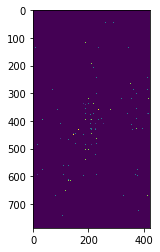

In [25]:
import numpy as np
from matplotlib import pyplot as plt
plt.imshow(data, interpolation='nearest')
plt.show()

In [104]:
data.shape

(787, 422)

In [61]:
train_processed_x.timestamp.max()

Timestamp('2020-01-31 19:00:00')

In [25]:
# For image normalization
pixels_norm = train_processed_x.num_of_posts.max() # [(train_processed_x.timestamp=='2020-01-31 13:00:00')].num_of_posts.max()
pixels_norm 

540

In [75]:
from tqdm import tqdm
from datetime import date, timedelta

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date) / np.timedelta64(1, 'h'))):
        yield start_date + timedelta(hours=n)

def generate_image_set(data, start_date=pd.Timestamp('2020-01-25T23'), end_date=pd.Timestamp('2020-01-25T23')):
    train_3d_images = []
    ground_truth = []
    # end_date = data.timestamp.max()
    
    end_date = end_date-timedelta(hours=5-1)
    
    for single_date in tqdm(daterange(start_date, end_date), total=len(list(daterange(start_date, end_date)))):
        three_d_image = []
        inner_end_date = single_date + timedelta(hours=5)
        ground_truth.append(generate_image(spec_timestamp=inner_end_date, input_data=data))
        for inner_single_data in daterange(single_date, inner_end_date):
            three_d_image.append(generate_image(spec_timestamp=inner_single_data, input_data=data))
        train_3d_images.append(three_d_image)
    return train_3d_images, ground_truth, single_date

In [70]:
all_dates_hourly = list(daterange(train_processed_x.timestamp.min(), train_processed_x.timestamp.max()))
print(len(all_dates_hourly))
for i in range(0, len(all_dates_hourly), len(all_dates_hourly) // 4):
    print(i)

9503
0
2375
4750
7125
9500


In [82]:
all_dates_hourly[7125]

Timestamp('2019-10-24 21:00:00')

In [76]:

train_X_0, train_y_0, last_date = generate_image_set(data=train_processed_x, start_date=pd.Timestamp('2019-01-01T00'), end_date=pd.Timestamp('2019-04-09T23'))
np.save('./train_X_0.npy', train_X_0)
np.save('./train_y_0.npy', train_y_0)
print(last_date)

100%|██████████| 2371/2371 [08:03<00:00,  4.90it/s]


2019-04-09 18:00:00


In [81]:
train_X_1, train_y_1, last_date = generate_image_set(data=train_processed_x, start_date=pd.Timestamp('2019-04-09T19'), end_date=pd.Timestamp('2019-07-17T22'))
np.save('./train_X_1.npy', train_X_1)
np.save('./train_y_1.npy', train_y_1)
print(last_date)

100%|██████████| 2375/2375 [08:32<00:00,  4.63it/s]


2019-07-17 17:00:00


In [83]:
train_X_2, train_y_2, last_date = generate_image_set(data=train_processed_x, start_date=pd.Timestamp('2019-07-17T18'), end_date=pd.Timestamp('2019-10-24T21'))
np.save('./train_X_2.npy', train_X_2)
np.save('./train_y_2.npy', train_y_2)
print(last_date)

100%|██████████| 2375/2375 [09:22<00:00,  4.22it/s]


2019-10-24 16:00:00


In [85]:
train_X_3, train_y_3, last_date = generate_image_set(data=train_processed_x, start_date=pd.Timestamp('2019-10-24T17'), end_date=pd.Timestamp('2020-01-31T19'))
np.save('./train_X_3.npy', train_X_3)
np.save('./train_y_3.npy', train_y_3)
print(last_date)

100%|██████████| 2374/2374 [09:11<00:00,  4.30it/s]


2020-01-31 14:00:00


In [32]:
train_X_0, train_X_1, train_X_2, train_X_3 = np.load('./train_X_0.npy'), np.load('./train_X_1.npy'), np.load('./train_X_2.npy'), np.load('./train_X_3.npy')

In [33]:
train_y_0, train_y_1, train_y_2, train_y_3 = np.load('./train_y_0.npy'), np.load('./train_y_1.npy'), np.load('./train_y_2.npy'), np.load('./train_y_3.npy')

In [87]:
train_X = train_X_0+train_X_1+train_X_2+train_X_3

In [93]:
np.array(train_X).shape

(9495, 5, 787, 422)

In [90]:
train_y = train_y_0+train_y_1+train_y_2+train_y_3

In [94]:
np.array(train_y).shape

(9495, 787, 422)

In [268]:
from tensorflow.keras.layers import Input, Conv2D, Conv3D, Concatenate, MaxPooling2D, UpSampling2D
import keras 

def get_unet_model(img_size):

    inputs = keras.Input(shape=img_size+(5, 1))
    
    # --- Encoder ---
    # first conv layer
    conv_layer_1_1 = Conv3D(10, (1, 1, 3), activation='elu', padding='valid')(inputs)
    conv_layer_1_2 = Conv3D(20, (1, 1, 3), activation='elu', padding='valid')(conv_layer_1_1)
    conv_layer_1_3 = Conv3D(40, (3, 3, 1), activation='elu', padding='same')(conv_layer_1_2)
    
    conv_layer_2_1 = Conv3D(20, (3, 3, 1), activation='elu', padding='same')(conv_layer_1_3)
    conv_layer_2_2 = Conv3D(10, (3, 3, 1), activation='elu', padding='same')(conv_layer_2_1)
    outputs = Conv3D(1, 1, activation='elu', padding='same')(conv_layer_2_2)
    
    model = keras.Model(inputs, outputs)
    return model

In [ ]:
# ! pip install pydot
# keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [222]:
from tensorflow import keras
import tensorflow as tf


class ImgSequence(keras.utils.Sequence):
    
    def __init__(self, batch_size, img_size, images_paths, target_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.images_paths = images_paths
        self.target_paths = target_paths
        
    
    def __len__(self):
        length = 0
        # Each item in the sequence has a size of batch_size, this method returns the number of batches. Shoud be integer!
        # TODO: length calculation
        length = len(self.images_paths) // self.batch_size
        return length
    
    def __getitem__(self, idx):
        # x = np.zeros((self.batch_size, ) + self.img_size + (3, ), dtype="float32")
        # y = np.zeros((self.batch_size, ) + self.img_size + (1, ), dtype="uint8")
        """
        This method returns the batches themselves including images (x) and masks (y) as np.arrays.
        Correspondingly x contains the batch_size of the pet images, y the true segmentation of the images from x.
        Note:

                img / 255.0 for images, so that each value is adjacent to the interval [0, 1] 
                
        """
        
        # TODO x and y calculation
        batch_x = self.images_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.target_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        x = np.array([np.array(file_name).reshape((787, 422, -1, 1)) / float(pixels_norm*100) for file_name in batch_x])
        y = np.array([np.expand_dims(np.array(file_name), axis=(2, 3)) / float(pixels_norm*100) for file_name in batch_y])
        return x, y 
        

        

In [303]:
# Instantiate data Sequences for each split
batch_size = 16
train_gen = ImgSequence(batch_size=batch_size, img_size=(787, 422), images_paths=train_X[:100], target_paths=train_y[:100])
valid_gen = ImgSequence(batch_size=batch_size, img_size=(787, 422), images_paths=train_X[100:132], target_paths=train_y[100:132])

In [269]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
model2 = get_unet_model((787, 422))

In [270]:
model2.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.5, name="Adadelta"), loss=tf.keras.losses.MeanAbsoluteError())


# Train the model, doing validation at the end of each epoch.
epochs = 3
model2.fit(train_gen, validation_data=valid_gen, epochs=epochs)

Epoch 1/3
6/6 [==============================] - 17s 3s/step - loss: 1.2701e-04 - val_loss: 9.6221e-05
Epoch 2/3
6/6 [==============================] - 16s 3s/step - loss: 1.4144e-04 - val_loss: 1.0537e-04
Epoch 3/3
6/6 [==============================] - 17s 3s/step - loss: 1.4279e-04 - val_loss: 1.1440e-04


In [151]:
# model.save("./model.h5")
# model = keras.models.load_model('./model.h5')

In [271]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 787, 422, 5, 1)]  0         
                                                                 
 conv3d (Conv3D)             (None, 787, 422, 3, 10)   40        
                                                                 
 conv3d_1 (Conv3D)           (None, 787, 422, 1, 20)   620       
                                                                 
 conv3d_2 (Conv3D)           (None, 787, 422, 1, 20)   3620      
                                                                 
 conv3d_3 (Conv3D)           (None, 787, 422, 1, 40)   7240      
                                                                 
 conv3d_4 (Conv3D)           (None, 787, 422, 1, 20)   7220      
                                                                 
 conv3d_5 (Conv3D)           (None, 787, 422, 1, 10)   1810  

In [304]:

val_preds = model2.predict(valid_gen)

2/2 [==============================] - 2s 918ms/step


In [305]:
valid_gen.__getitem__(0)[0].shape

(16, 787, 422, 5, 1)

In [306]:
preds2 = model2.predict(np.expand_dims((valid_gen.__getitem__(1)[0][0]), axis=0))

1/1 [==============================] - 0s 151ms/step


In [323]:
true = valid_gen.__getitem__(1)[1][0][:, :, 0, 0]

In [331]:
pred = preds2[0, :, :, 0, 0]

In [365]:
abs(pred - true.mean()) / pred.mean()

0.9956172586485939

In [367]:
(np.array([10, 18, 20]) - np.array([6, 8, 10])) / np.array([4, 2, 2])

array([1., 5., 5.])

In [364]:
true.mean()

4.842157054951458e-07

In [374]:
x = abs(pred - true)/pred

/tmp/ipykernel_840692/3900899342.py:1: RuntimeWarning: invalid value encountered in true_divide
  x = abs(pred - true)/pred


In [414]:
np.argwhere(np.isnan(pred))

array([], shape=(0, 2), dtype=int64)

In [425]:
np.argwhere(np.isnan(np.nan_to_num(x, nan=0)))

array([], shape=(0, 2), dtype=int64)

In [419]:
true[395][41:45]

array([0., 0., 0., 0.])

In [420]:
pred[395][41:45]

array([-1.6033649e-05,  3.5614736e-04,  0.0000000e+00,  1.5630417e-04],
      dtype=float32)

In [424]:
abs(np.array([0]) - np.array([0])) / np.array([0])

/tmp/ipykernel_840692/451706818.py:1: RuntimeWarning: invalid value encountered in true_divide
  abs(np.array([0]) - np.array([0])) / np.array([0])


array([nan])

In [410]:
787 * 422

332114

In [409]:
x.shape

(787, 422)

In [426]:
np.mean(np.nan_to_num(x, nan=0))

0.9889564473347306

In [391]:
for i in range(true.shape[0]):
    if true[i].sum() > 0:
        print(i, true[i])
        break

31 [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.      

In [397]:
pred[31].argmax()

238

In [396]:
pred[31].min()

-2.3424625e-05

In [403]:
true[31][279]

0.001851851851851852

In [404]:
true[31][0]

0.0

In [405]:
np.argsort(true[31])[::-1]

array([279, 421, 156, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 132,
       131, 130, 117, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       118, 129, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 155,
       157, 105, 158, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
       195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207,
       184, 183, 182, 169, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 170, 181, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       106, 104, 209,  51,  27,  28,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  26,  25,  24,  11,   1,   2,   3,   4,   5,   6,   7,   8,
         9,  10,  12,  23,  13,  14,  15,  16,  17,  18,  19,  20,  21,
        22,  50,  52, 103,  53,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  9

In [406]:
np.argsort(pred[31])[::-1]

array([238, 236, 239, 299, 323, 404, 286, 241, 405, 257, 407, 319, 295,
       290,  85, 139, 217, 137, 306, 235, 144, 406, 240, 289, 222, 255,
       224, 158,  50, 223,  88, 220, 146, 136, 408, 145, 230, 229, 288,
        40, 141, 292,  44, 302, 142, 259, 140, 156, 388, 304,  34, 135,
       216, 325,  84,  51, 151, 382,  41, 154, 253,  35, 147,  45, 411,
       389, 383, 252, 410, 161, 163, 164, 165, 162, 167, 160,  14, 150,
       149, 148, 166, 210, 168, 198, 191, 192, 193, 194, 195, 196, 197,
       199, 189, 200, 201, 202, 203, 204, 205, 206, 190, 188, 169, 177,
       170, 171, 172, 173, 174, 175, 176, 178, 187, 179, 180, 182, 183,
       184, 185, 186, 181, 124, 134,  58,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        59,  57,  80,  56,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  52,  53,  54,  55,  79,  81, 133,
       112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 20

In [361]:
abs(0.8 - 0.8) / 0.8

0.12499999999999997

In [299]:
valid_gen.__getitem__(1)[1][0, :, :, 0, 0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

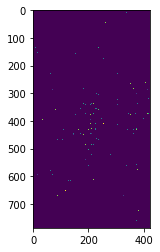

In [169]:
import numpy as np
from matplotlib import pyplot as plt
plt.imshow(train_y[-120:][0], interpolation='nearest')
plt.show()

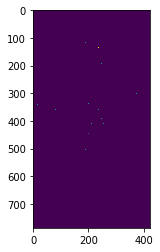

In [334]:
valid_gen.__getitem__(1)[1][0, :, :, 0, 0]
import numpy as np
from matplotlib import pyplot as plt
plt.imshow(true, interpolation='nearest')
plt.show()

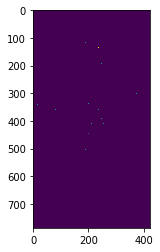

In [296]:
import numpy as np
from matplotlib import pyplot as plt
plt.imshow(valid_gen.__getitem__(1)[1][0, :, :, 0, 0], interpolation='nearest')
plt.show()

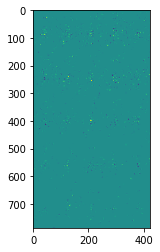

In [279]:
import numpy as np
from matplotlib import pyplot as plt
plt.imshow(np.squeeze(preds2[0], axis=2)*100, interpolation='nearest')
plt.show()

In [182]:
np.squeeze(val_preds[10], axis=2).sum(0)

array([[-3.9500916],
       [-5.1042213],
       [-5.1566477],
       [-5.150398 ],
       [-5.150473 ],
       [-5.1503243],
       [-5.150615 ],
       [-5.1507993],
       [-5.1508746],
       [-5.149775 ],
       [-5.1503854],
       [-5.1509824],
       [-5.1507697],
       [-5.150171 ],
       [-5.150559 ],
       [-5.1506753],
       [-5.150458 ],
       [-5.150762 ],
       [-5.1497903],
       [-5.150087 ],
       [-5.150582 ],
       [-5.1513906],
       [-5.150003 ],
       [-5.1509023],
       [-5.1505895],
       [-5.15052  ],
       [-5.150659 ],
       [-5.1504283],
       [-5.1505103],
       [-5.1508126],
       [-5.1500163],
       [-5.150431 ],
       [-5.150458 ],
       [-5.1506467],
       [-5.149964 ],
       [-5.149709 ],
       [-5.1507087],
       [-5.1522   ],
       [-5.150787 ],
       [-5.1490674],
       [-5.1473565],
       [-5.1503415],
       [-5.153519 ],
       [-5.1513677],
       [-5.147989 ],
       [-5.150727 ],
       [-5.151712 ],
       [-5.15